## Multi purpose web app template for time series prediction use cases

### Table of contents:
* [Project Definition](#0)
    * [Project Overview](#0.0)
    * [Problem Statement](#0.1)
    * [Metrics](#0.2)
* [Define parameters](#1)
* [Import packages](#2)
* [Analysis](#3)
* [Methodology](#4)
    * [Data Exploration ](#4.0)
    * [Model Development](#4.1)
    * [Find programatically best model ](#4.2)
* [Results](#5)
    * [Averaged coefficient of determination one test data](#5.0)
    * [Learning Curve](#5.1)
    * [Hyperparameter Performance Plot](#5.2)
    * [Feature importance](#5.3)
    * [Prediction Plots](#5.4)
    * [Backend API Test](#5.5)  
    * [End to End summary](#5.6)    
* [Conclusion](#6)
* [Model Deployment](#7)

## Project Overview<a class="anchor" id="0"></a>
### Project Overview<a class="anchor" id="0.0"></a>
This project aims to build a multi purpose web app template, that makes developement of rapid prototype web apps for time series predictions easy.

As example use case I chose Gold price prediction.

The app delivers:

* Easy to setup time series prediction web app
* Easy ML development and deployment pipeline for "quick and dirty" prototypes
* Based on tensorflow serving which supports serving and inference of multiple models with GPU acceleration


The model developement is done with the following steps:
- <b>Defining parameters for the model:</b>
    - Here will be all parameters defined, ranging from asset to predict, over input and output sequence lenths, to lstm topoligy parameters to variate iver during search of the best model.
- <b>Analysis:</b>
    - here the data will be visualized and analyzed.
- <b>Methology:</b>
    - here the data will besplitted into train test split and transformed into a 3d array consisting of a moving window over the time series.
    - the lstm model will be build and trained oer different sets of parameters to find the best model.
- <b>Results:</b>
    - here the model will be scored and predictions will be visualized.
    - main findings about the model performace will be summarized.
- <b>Conclusions:</b>
    - outlook is given how to improve the model.
- <b>Deployment:</b>
    - here the developed model is retrained on the full dataset and saved for simple tensorflow serving backend.


### Project Motivation <a class="anchor" id="0.0"></a>
This project aims to build a multi purpose web app template for time series prediction, that makes developement of rapid prototype web apps for several domains as easy as possible. Therefore, it is build in a way, where the input and output length of the model is variable and can be used to predict different use cases like stock market prediction, weather predictions and more use cases with quantitative input values. 
Furthermore, the deployment of the ML model is easy, as a tensorflow serving backend with a UI for controlling, which models are online, is used.
The aim of this project is to have a template for fast prototyping for different use cases, that can be used to show potential customers the potential of AI software for timeseries prediction.

### Problem definition <a class="anchor" id="0.1"></a>

As example use case I chose Gold price prediction. The web app uses a LSTM neural network to forecast 60 days of Gold prices by querying yahoo finance API and filtering last 60 datapoint with all available features ('Open','High','Low','Close', 'Volume'). This prediction should be accessed in terms of accuracy of the prediction with a suitable metric for time series regression and show how the accuracy changes with increasing timesteps into the future.

Why financial price action forecasting and why lstm?

Although being one of the hardest task for machine learning, one of the most researched topics in financial industry is the developement of machine based investing strategies. Approximately 90% of all trading decision are nowadays done from machines. With the emergence of easy accessible neural net based frameworks during last 6 years, a lot of effort is put into developement of assets price prediction models based on different architectures of neural networks. One of the promising ones are recurrent networks, that can captures the relationship of different variables to a target value as well as pattern over time (memory). One particular type that is used here is the long short term neural network, which uses a mechanism to improve the short term memory and thus the capability to remember temporal patterns.

### Metrics<a class="anchor" id="0.2"></a>

As metric I chose coefficient of determination, as this is well suited for regression problems like time series forecasting. As time series forecasting outputs a times series, that has to resemble the truth as accurate as possible, the coefficient of determination metric quantifies the shape and deviation from the ground truth.

### Define parameters <a class="anchor" id="1"></a>

In [4]:
tickerSymbol = 'GC=F' # prediction asset
start_date = '2005-01-01' # start date for historical stock data
end_date = '2020-10-30'# end date for historical stock data
export_path = './simple_tensorflow_serving/models/lstm/1' # model export path
input_len = 60 # length of input sequence
output_len = 60 # length into future to predict
test_size = .1 # test split portion
prediction_col = "Close" # prediction column
test_data_multiplicator = 10 # no of output_len test piece in test data set
n_splits = 500 # number of x folds for cross validation

# specify parameters for grid search optimisation
parameters = {
    'estimator__epochs': [1], # amount of passes through train set during training
    'estimator__batch_size': [1024],
    'estimator__optimizer':['Adam', 'Adamax'], #['RMSprop', 'Adam', 'Adamax', 'sgd']
    'estimator__dropout': [0.2],
    'estimator__activation': ['tanh', 'sigmoid'],
    'estimator__recurrent_activation': ['tanh', 'sigmoid'],
    'estimator__hidden_1_len': [30],
    'estimator__hidden_2_len': [30],
}

### Import packages and data <a class="anchor" id="2"></a>

In [5]:
#!conda install -c conda-forge shap
#import shap
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Reshape
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import TransformedTargetRegressor


#from imblearn.pipeline import make_pipeline
#from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.decomposition import PCA
#from sklearn.ensemble import RandomForestRegressor
#import xgboost as xgb

import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import os 
import yfinance as yf
import datetime
import tempfile
import requests

## Analysis <a class="anchor" id="3"></a>
### Data Exploration <a class="anchor" id="3.0"></a>

In [6]:
# get data on this ticker from yahoo finance API
df = yf.download(tickerSymbol, start=start_date, end=end_date)[['Open','High','Low','Close', 'Volume']]
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2005-01-03,431.000000,431.000000,431.000000,428.700012,4
2005-01-04,428.500000,428.500000,428.500000,428.500000,108
2005-01-05,425.700012,425.700012,425.700012,426.600006,2
2005-01-06,421.000000,421.000000,421.000000,421.000000,1
2005-01-07,423.700012,423.700012,418.700012,418.899994,1


In [7]:
# Reset index and sort DataFrame by date
df = df.reset_index().sort_values('Date')
df.head()

,Date,Open,High,Low,Close,Volume
0,2005-01-03,431.000000,431.000000,431.000000,428.700012,4
1,2005-01-04,428.500000,428.500000,428.500000,428.500000,108
2,2005-01-05,425.700012,425.700012,425.700012,426.600006,2
3,2005-01-06,421.000000,421.000000,421.000000,421.000000,1
4,2005-01-07,423.700012,423.700012,418.700012,418.899994,1


In [9]:
#checking ranges of data columns
df.describe()

,Open,High,Low,Close,Volume
count,3949.000000,3949.000000,3949.000000,3949.000000,3949.000000
mean,1170.440010,1176.552368,1163.819144,1170.273158,4983.808306
std,368.652299,370.909206,366.002564,368.537315,27197.058090
min,412.000000,413.600006,410.100006,412.600006,0.000000
25%,917.000000,924.000000,909.500000,915.900024,28.000000
50%,1236.000000,1242.300049,1229.099976,1235.699951,114.000000
75%,1366.800049,1376.000000,1358.000000,1368.500000,404.000000
max,2045.500000,2063.000000,2040.000000,2051.500000,386334.000000


<b>Result:</b> The magnitutes differ largely between the features and may be an indication, that a scaling is necessary.

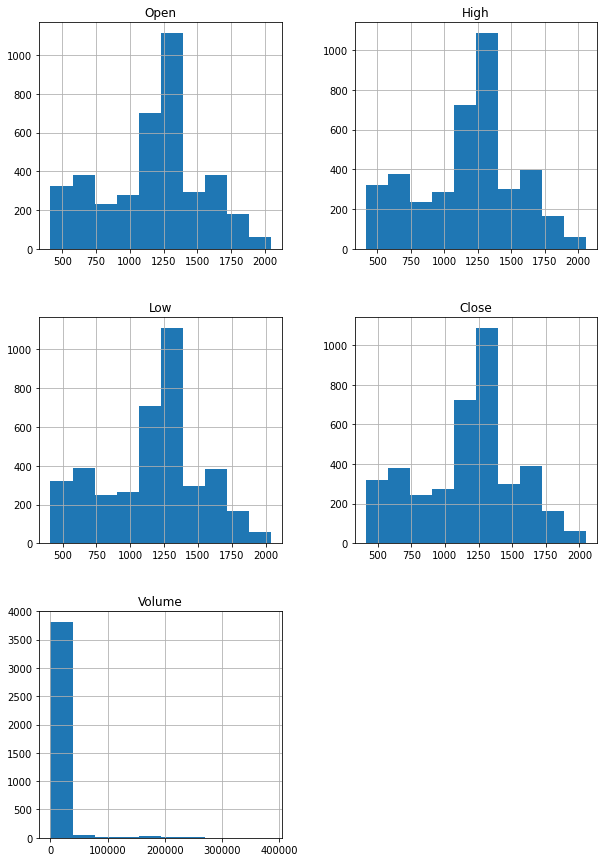

In [16]:
df.hist(figsize=(10,15));

<b>Result:</b> The distribution of the Open, High, Low and Close price are very similar and indicale a bimodal distribution, show a mean around 600 and 1200 Dollars. The volume data on the other hand is heavily skewed to the right. The strong similarity of the features might be contra productive for the model due to colliniarity. Thus calculating features importance might be helpful.

In [8]:
# checking whether missing values are present in dataset
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

<b>Result:</b> No missing values present in data set. Thus no impution necessary.

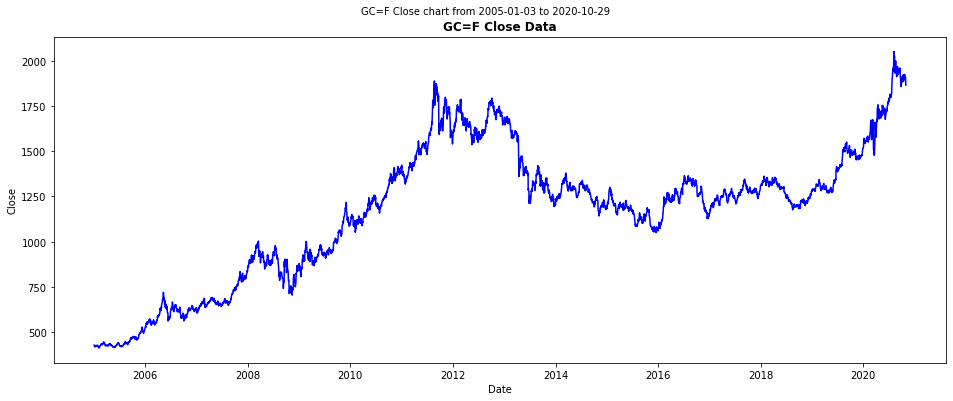

In [6]:
# plot data
plt.figure(figsize = (16,6))
plt.plot(df['Date'], df[prediction_col], color='b')
plt.xlabel(df.columns[0])
plt.ylabel(prediction_col)
plt.suptitle(f'{tickerSymbol} {prediction_col} chart from {df.Date.min().date()} to {df.Date.max().date()}', fontsize=10, y=.95)
plt.title(f'{tickerSymbol} {prediction_col} Data', fontsize=12, fontweight='bold')
plt.show()

<b>Result:</b> It is clearly noticable that the data is not very cyclical on the considered time frame. This might make it difficult (and partly impossible) for the algorithm to capture longterm pattern.

## Methodology <a class="anchor" id="4"></a>
As I am using a LSTM mode for forecasting, we will need to transform the data into a moving window of fixed length moving over the data and predicting another fixed length of the same data in the future.
Furthermore, I split the data into train and test split, with the test split being in the future from the train split, in order to have a held out data set for scoring and avoid data leakage from future data points onto the current predctions. For that, I will use a special cross validation method from sklearn especially for time series.

### Preprocessing <a class="anchor" id="4.0"></a>


In [7]:
# train test split
df_train = df.iloc[0:-test_data_multiplicator*output_len]
df_test = df.iloc[-test_data_multiplicator*output_len-1:-1]

X_train, y_train = df_train.drop(['Date'], axis=1).to_numpy(), df_train[prediction_col].to_numpy()
X_test, y_test = df_test.drop(['Date'], axis=1).to_numpy(), df_test[prediction_col].to_numpy()

<b>Result:</b> The input and target data have to separated and converted to arrays for training of the ML estimator. The Date column is ommitted, as it is linearly increasing and does not deliver any variable information to the algorithm. One could, with more time, generate catigorical features of the Date column different weekdays.

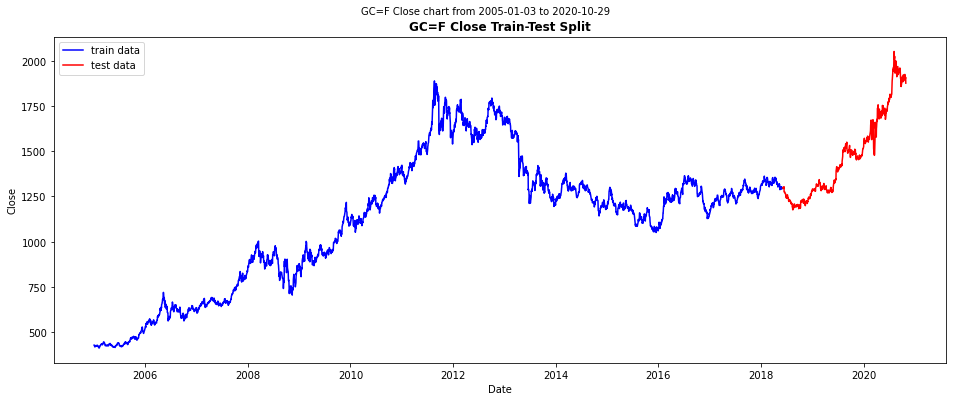

In [8]:
# plot train test split
plt.figure(figsize = (16,6))
plt.plot(df_train['Date'], df_train[prediction_col], color='b', label='train data')
plt.plot(df_test['Date'], df_test[prediction_col], color='r', label='test data')
plt.xlabel(df.columns[0])
plt.ylabel(prediction_col)
plt.suptitle(f'{tickerSymbol} {prediction_col} chart from {df.Date.min().date()} to {df.Date.max().date()}', fontsize=10, y=.95)
plt.title(f'{tickerSymbol} {prediction_col} Train-Test Split', fontsize=12, fontweight='bold')
plt.legend()
plt.show()

<b>Result:</b> The test dataset has to be in the future of the train data set to avoid data leakage. In this case it has the disadvantage that the test peak is outside of the values range of the train data set. This will cause problems with scaling in the model evaluation on the test data set.

In [9]:
# transform time-series into moving window (3d array)
def transform_3d(X, y, input_len, output_len):
    '''
    Transforming 2d arrays into 3d arrays with overlapping time windows moving through times series.
    
    ARGS:
        X (2d array): model input values as time series.
        y (2d array): model target values as time series.
        input_len (int): input length of time series
        output_len (int): output length of time series
    
    RETURNS:
        X (3d array): model input values as moving windows over time series.
        y (3d array): model target values as moving windows over time series.   
    '''
    X_out = []
    y_out = []
    for i in range(input_len, X.shape[0]-output_len+1):
        X_out.append(X[i-input_len:i])
        y_out.append(y[i:i+output_len])
    return np.array(X_out), np.array(y_out)

![transform_data](static/MachineLearning_SequentialDataSelection.png)

<b>Result:</b> The data has to be transformed into a 3d array to implement a moving window. The moving window is necesary to train the model on prediction for an arbitrary time step.

In [10]:
# transform time-series into moving window (3d array)
X_train, y_train = transform_3d(X_train, y_train, input_len, output_len)
X_test, y_test = transform_3d(X_test, y_test, input_len, output_len)

# check shape of train and test data
print('Shape of X Train:', X_train.shape, '\nShape of y Train:', y_train.shape)
print('\nShape of X Test:', X_test.shape, '\nShape of y Test:', y_test.shape)

Shape of X Train: (3230, 60, 5) 
Shape of y Train: (3230, 60)

Shape of X Test: (481, 60, 5) 
Shape of y Test: (481, 60)


<b>Result:</b> The time series has been successdully converted into a 3d array of moving (and overlapping) windows.

In [11]:
# scaling data with multi scalers for each moving window (depricated)
'''
scalers = {}
for i in range(X_train.shape[0]):
    scalers[i] = MinMaxScaler()
    X_train[i, :, :] = scalers[i].fit_transform(X_train[i, :, :]) 

for i in range(X_test.shape[0]):
    X_test[i, :, :] = scalers[i].transform(X_test[i, :, :])
'''

'\nscalers = {}\nfor i in range(X_train.shape[0]):\n    scalers[i] = MinMaxScaler()\n    X_train[i, :, :] = scalers[i].fit_transform(X_train[i, :, :]) \n\nfor i in range(X_test.shape[0]):\n    X_test[i, :, :] = scalers[i].transform(X_test[i, :, :])\n'

<b>Result:</b> I had the idea to implement a separate scaler for every moving windows. This didn't improve the scores as I hoped. A single scaler over all extrema would be better for long term pattern, but would require in the frontend to increase the input length and amount of data necessary from input API.

### Model Development <a class="anchor" id="4.1"></a>

In [12]:
# define lstm topology
def create_lstm_model(optimizer = 'adam',
                      kernel_initializer = 'glorot_uniform', 
                      dropout = 0.2,
                      metrics = ['accuracy'], 
                      loss = 'mean_squared_error',
                      recurrent_activation='tanh',
                      activation='tanh',
                      hidden_1_len = 60,
                      hidden_2_len = 60,
                      output_len=output_len):
    '''
    Stacked and fully connected Long Short-Term Memory Network
    
    ARGS:
        optimizer (str): name of opimizer algorithm to find error minimum in learning process.
        kernel_initializer (str): Initializers define method to set the initial weights of NN layers.
        dropout (float): frequency to randomly set input units to 0 at each step during training time to prevent overfitting
        metrics (list): error metric to calculate for validation
        loss (str): error metric to use for learning process of neural net
        recurrent_activation (str): activation function for recurrent outputs
        activation (str): activation function for outputs to next neural net layers
        hidden_1_len (int): number of neurons in first hidden layer
        hidden_2_len (int): number of neurons in second hidden layer
        output_len (int): number of neurons in output layer
    
    RETURNS:
        lstm_model (keras sequencial object): keras lstm estimator
    
    '''
    lstm_model = Sequential()
    lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2]), name = 'input'))
    
    # layers: LSTM with returning sequence so that the next LSTM layers have a sequence input
    lstm_model.add(LSTM(units = hidden_1_len, 
                        activation=activation,
                        recurrent_activation=recurrent_activation,
                        return_sequences=True)) 
    
    lstm_model.add(Dropout(dropout))
    
    lstm_model.add(LSTM(units = hidden_2_len,
                        activation=activation,
                        recurrent_activation=recurrent_activation,
                        return_sequences=True))
    
    lstm_model.add(Dropout(dropout))
    
    lstm_model.add(LSTM(units = output_len, activation=activation, name = 'output'))
    
    lstm_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

    return lstm_model

In [13]:
# wrap keras for sklearn
lstm = KerasRegressor(build_fn = create_lstm_model, 
                      epochs = 100, 
                      batch_size = 1024,
                      dropout = 0.1,
                      verbose = 0)

In [14]:
# build pipeline
pipeline = Pipeline([ # todo: 3d scaling within pipeline
    #('scaler', StandardScaler()),
    #('pca', PCA()),
    #('preprocessor', preprocess_LSTM()),
    ('estimator', lstm),

])


In [15]:
# get pipeline parameters
pipeline.get_params()

{'memory': None,
 'steps': [('estimator',
   <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor at 0x150a14f40>)],
 'verbose': False,
 'estimator': <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor at 0x150a14f40>,
 'estimator__epochs': 100,
 'estimator__batch_size': 1024,
 'estimator__dropout': 0.1,
 'estimator__verbose': 0,
 'estimator__build_fn': <function __main__.create_lstm_model(optimizer='adam', kernel_initializer='glorot_uniform', dropout=0.2, metrics=['accuracy'], loss='mean_squared_error', recurrent_activation='tanh', activation='tanh', hidden_1_len=60, hidden_2_len=60, output_len=60)>}

### Find programatically best model <a class="anchor" id="4.2"></a>

In [16]:
# define x fold validation method for grid search
tscv = TimeSeriesSplit(n_splits=n_splits) #int(X_train.shape[0]-input_len)

# fit estimator and find optimum set for parameters
cv = GridSearchCV(pipeline, param_grid=parameters, cv=tscv, n_jobs=-1, return_train_score=True, verbose=2)

# define target transform wrapper, that rescales output batches
cv_scaled = TransformedTargetRegressor(regressor=cv, transformer=MinMaxScaler()) #to do proper target scaling
model = cv_scaled.fit(X_train, y_train)

Fitting 500 folds for each of 8 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 74.6min finished


<b>Note:</b> The time series cross validation method has been chosen in order to avoid training on data from the future and thus data leakage.
Gridsearch is used to find best parameter set and lstm topology within the specified parameter ranges. The parameter range should be increased if enough computing power is available.

In [69]:
# output cv results
model.regressor_.cv_results_

{'mean_fit_time': array([10.36232198, 13.07389584, 11.16179092, 13.04924948, 10.57753078,
         9.77623067,  9.67977329,  9.40461097]),
 'std_fit_time': array([2.62808395, 2.87833248, 2.25876166, 2.60885602, 2.43730924,
        2.56638209, 2.45813151, 2.49080494]),
 'mean_score_time': array([2.54687666, 2.70158036, 2.09629488, 2.88417074, 1.28366175,
        1.8011423 , 1.93208517, 2.12709818]),
 'std_score_time': array([0.93625566, 0.64917206, 0.94765038, 0.98698628, 0.5024729 ,
        0.77469097, 0.89688869, 0.8363095 ]),
 'param_estimator__activation': masked_array(data=['tanh', 'tanh', 'tanh', 'tanh', 'sigmoid', 'sigmoid',
                    'sigmoid', 'sigmoid'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_estimator__batch_size': masked_array(data=[1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024],
              mask=[False, False, False, False, False, False, False, False],
        fill

In [18]:
# check lstm topology of best model
model.regressor_.best_estimator_['estimator'].model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 30)            4320      
_________________________________________________________________
dropout (Dropout)            (None, 60, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 30)            0         
_________________________________________________________________
output (LSTM)                (None, 60)                21840     
Total params: 33,480
Trainable params: 33,480
Non-trainable params: 0
_________________________________________________________________


## Results <a class="anchor" id="5"></a>

#### Averaged coefficient of determination one test data<a class="anchor" id="5.0"></a>

In [19]:
print('Best model parameter set:', model.regressor_.best_params_)
print('\n\nR2 Score for best model on validation dataset:', model.regressor_.best_score_)

Best model parameter set: {'estimator__activation': 'sigmoid', 'estimator__batch_size': 1024, 'estimator__dropout': 0.2, 'estimator__epochs': 1, 'estimator__hidden_1_len': 30, 'estimator__hidden_2_len': 30, 'estimator__optimizer': 'Adam', 'estimator__recurrent_activation': 'sigmoid'}


R2 Score for best model on validation dataset: -0.06660223495401442


In [45]:
# store predictions
y_pred = model.predict(X_test)

In [21]:
# r2 score on test dataset
r2_scores = []
for i in range(y_test.shape[0]):
    r2_scores.append(r2_score(y_test[i,:], y_pred[i,:]))
print('Averaged R\u00b2 Score:', np.mean(r2_scores).round(2),'\u00B1', np.std(r2_scores).round(2))

Averaged R² Score: -230.34 ± 209.44


<b>Result:</b> The best coefficient of determination would be 1. Although being slightly better on the validation data set, the score is far from optimum on the test data set and indicates potential for improvement on unseen data.
The cause is, that the test data is outside of the value range of the train data, leading to input values the model has never seen.

#### Learning Curve<a class="anchor" id="5.1"></a>

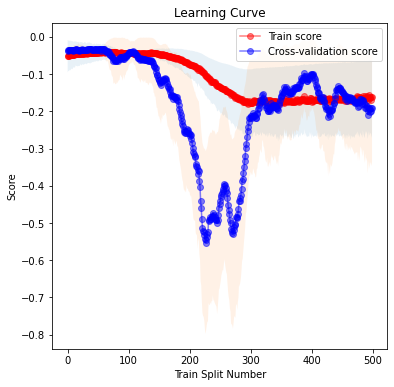

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.set_title("Learning Curve")
ax.set_xlabel("Train Split Number")
ax.set_ylabel("Score")

train_sizes = range(model.regressor_.n_splits_)

train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = \
np.empty(0), np.empty(0), np.empty(0), np.empty(0)

for i in range(model.regressor_.n_splits_):
    train_scores_mean = np.append(train_scores_mean, model.regressor_.cv_results_['split{}_train_score'.format(i)].mean())
    train_scores_std = np.append(train_scores_std, model.regressor_.cv_results_['split{}_train_score'.format(i)].std())
    test_scores_mean = np.append(test_scores_mean, model.regressor_.cv_results_['split{}_test_score'.format(i)].mean())
    test_scores_std = np.append(test_scores_std, model.regressor_.cv_results_['split{}_test_score'.format(i)].std())


# Plot learning curve
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         )
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         )
ax.plot(train_sizes, train_scores_mean, 'o-',
                 label="Train score", alpha=.5, color='r')
ax.plot(train_sizes, test_scores_mean, 'o-',
                 label="Cross-validation score", alpha=.5, color='b')
ax.legend(loc="best")
plt.show()

<b>Result:</b> It is clearly noticable that the performance of the model decreases with increasing training samples. This indicates overfitting on training data. The biggest deviation is in the middle of the dataset where the Gold price peaks. That means the model is not  adapted to extreme price deviations from the average baseline, which it has not seen.

#### Hyperparameter Performance Plot<a class="anchor" id="5.2"></a>

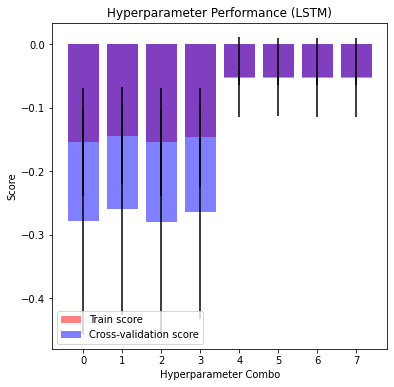

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.set_title("Hyperparameter Performance (LSTM)")
ax.set_xlabel("Hyperparameter Combo")
ax.set_ylabel("Score")

feature_combo = range(len(model.regressor_.cv_results_["mean_train_score"]))
train_scores_mean = model.regressor_.cv_results_["mean_train_score"]
train_scores_std = model.regressor_.cv_results_["std_train_score"]
test_scores_mean = model.regressor_.cv_results_["mean_test_score"]
test_scores_std = model.regressor_.cv_results_["std_test_score"]


# Plot parameter performance curve
ax.bar(feature_combo, train_scores_mean, yerr=train_scores_std,
                 label="Train score", alpha=.5, color='r')
ax.bar(feature_combo, test_scores_mean, yerr=test_scores_std,
                 label="Cross-validation score", alpha=.5, color='b')
ax.legend(loc="best")
plt.show()

In [74]:
# output cv results
model.regressor_.cv_results_['param_estimator__activation']

masked_array(data=['tanh', 'tanh', 'tanh', 'tanh', 'sigmoid', 'sigmoid',
                   'sigmoid', 'sigmoid'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object)

<b>Result:</b> This plot shows whether a particular hyper parameter combination has a significant impact oh the score. In this case, the sigmoid as activation function between layers is significant better than tanh. Other runs I performed showed that 30 hidden layers are better than 60, in addition to saving training time. The process of increasing the model performance is iterative and requires several trial and errors.

#### Feature importance<a class="anchor" id="5.3"></a>

In [75]:
# Source: https://stackoverflow.com/questions/60690151/question-about-permutation-importance-on-lstm-keras
'''
DE = shap.DeepExplainer(model, X_train) # X_train is 3d numpy.ndarray
shap_values = DE.shap_values(X_test, check_additivity=False) # X_test is 3d numpy.ndarray

shap.initjs()
shap.summary_plot(
    shap_values[0], 
    X_test,
    feature_names=df.columns.tolist(),
    max_display=50,
    plot_type='bar')
''' # todo: solve install error of shap

"\nDE = shap.DeepExplainer(model, X_train) # X_train is 3d numpy.ndarray\nshap_values = DE.shap_values(X_validate_np, check_additivity=False) # X_validate is 3d numpy.ndarray\n\nshap.initjs()\nshap.summary_plot(\n    shap_values[0], \n    X_validate,\n    feature_names=list_of_your_columns_here,\n    max_display=50,\n    plot_type='bar')\n"

<b>Result:</b> My conda has problems to build shap during installation. After fixing this issue, I will work on vizualizing the feature importance of the input data.

#### Prediction Plots<a class="anchor" id="5.4"></a>

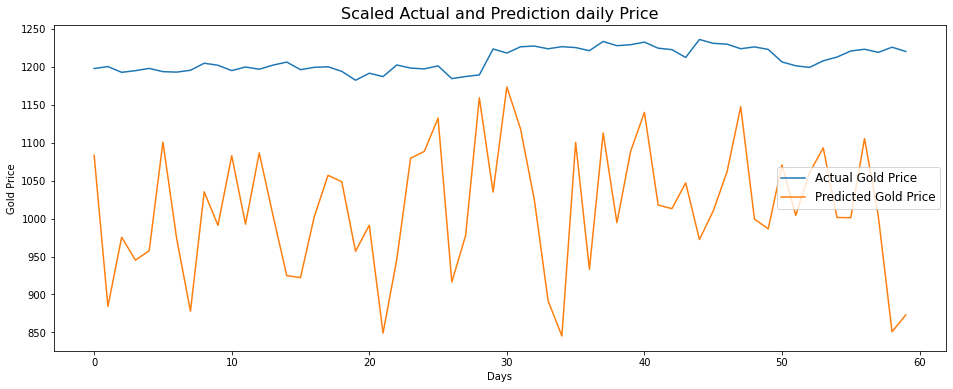

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(y_test[0], label = 'Actual Gold Price')
ax.plot(y_pred[0], label = 'Predicted Gold Price')
plt.title('Scaled Actual and Prediction daily Price', fontsize=16)
plt.xlabel('Days')
plt.ylabel('Gold Price')
plt.legend(fontsize=12, loc='best')
plt.show();

<b>Result:</b> The prediction is oscillating below ground truth.

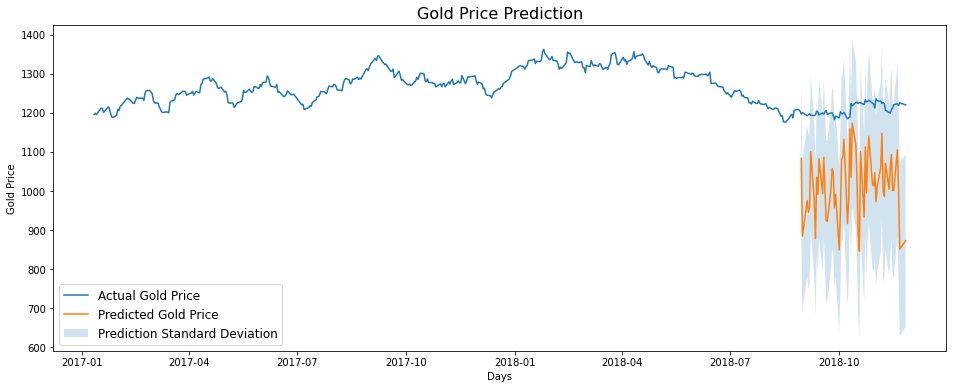

In [36]:
errors = y_pred - y_test
stds = errors.std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(df['Date'].iloc[3000:(-df_test.shape[0] + 2*output_len -1)], df[prediction_col].iloc[3000:(-df_test.shape[0] + 2*output_len -1)], label = 'Actual Gold Price')
ax.plot(df_test['Date'].iloc[output_len:2*output_len], y_pred[0], label = 'Predicted Gold Price', )
ax.fill_between(df_test['Date'].iloc[output_len:2*output_len], y_pred[0]-stds, y_pred[0]+stds,alpha=.2, label='Prediction Standard Deviation')
plt.title('Gold Price Prediction', fontsize=16)
plt.xlabel('Days')
plt.ylabel('Gold Price')
plt.legend(loc='best', fontsize=12)
plt.show();

<b>Result:</b> The predictions show large deviations, inaccuracies in the magnitude of the scaling and a high standard variation. 

#### Backend API Test<a class="anchor" id="5.5"></a>
In order to the the API, the simple tensorflow serving backend has to run.

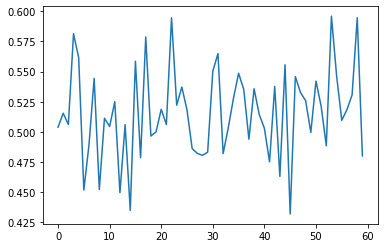

In [26]:
endpoint = "http://127.0.0.1:8500"
input_data = {
      #"model_name": "tensorflow_template_application_model",
      #"model_version": 1,
      #"signature_name": "serving_default",
      "data": {
          "input": [X_test[-1].tolist()],
      }
  }
result = requests.post(endpoint, json=input_data)
plt.plot(result.json()['output'][0]);

### End to End summary <a class="anchor" id="5.6"></a>

A web app that uses a LSTM neural network has been build. It forecasts 60 days of Gold prices by querying yahoo finance API and filtering last 60 datapoint with all available features ('Open','High','Low','Close', 'Volume'). This prediction should was accessed in terms of accuracy of the prediction with a coefficient of determination metric and standard deviation for the forecast has been calculated.

Although being slightly better on the validation data set, the coefficient of determination is far from optimum on the test data set and indicates potential for improvement on unseen data.
It is clearly noticable that the performance of the model decreases with increasing training samples. This indicates overfitting on training data. 
The biggest deviation is in the middle of the dataset where the Gold price peaks. That means the model is not adapted to extreme price deviations from the average baseline, which is outside of the value range of the train data, leading to input values the model has never seen.
In consequence prediction is oscillating below ground truth.
Furthermore, the predictions show large deviations, inaccuracies in the magnitude of the scaling and a high standard variation. 
Nevertheless, one insight is that the sigmoid as activation function between layers is significant better than tanh. Also the 30 hidden neurons instead of 60 are better in terms of accuracy and less overfitting.

## Conclusion <a class="anchor" id="6"></a>

The model and preprocessing has to be developed further to gain accuracy in magnitude and shape of the predictions.
That means to:
- integrate preprocess and feature scaling into pipeline
- build ensemble model with additional estimators
- calculate feature importance on preds and subsequent feature engineering 

Antother topic is to calculate the standard deviation in the frontend, for instance:
- calculate and show $R^2$ in frontend
- show confidence interval on prediction lines
    - for that store standard deviations for every prediction and future timestep in sqlite database

The prediction of stock prices is one of the most difficult tasks in economics and especially in machine learning. Furthermore, successful models tend to become inaccurate with time, so that temporary gains not a guarantee to succeed in the future. Therefore, a continouus training and deployment based on a timer could be implemented.




## Deployment<a class="anchor" id="7"></a>

In [27]:
# X y split whole dataset
X_full, y_full = df.drop(['Date'], axis=1).to_numpy(), df[prediction_col].to_numpy()

# transform time-series into moving window (3d array)
X_full, y_full = transform_3d(X_full, y_full, input_len, output_len)

# Train on complete data set
model = cv_scaled.fit(X_full, y_full)

Fitting 500 folds for each of 8 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 80.4min finished


The model has to be trained on full data set before deployment to close the data gap to currently queried values.

In [28]:
# save model in simple tensorflow serving model folder
tf.keras.models.save_model(
    model.regressor_.best_estimator_['estimator'].model,
    export_path,
    overwrite=True,     
)

INFO:tensorflow:Assets written to: ./simple_tensorflow_serving/models/lstm/1/assets
